# Importing Libraries

In [1571]:
import pandas as pd
import seaborn as sns
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.display import Image
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import roc_curve, roc_auc_score
random.seed(13261058)

# Importing Data

## Training Data

In [1512]:
Census = pd.read_csv("C:/Personal/UC BANA Flex 5/adult.csv")

## Test Data

In [1513]:
Census_test = pd.read_csv("C:/Personal/UC BANA Flex 5/Census_Test.csv")

# Data Cleaning

There are 24 duplicate records(0.07%) found in the Census Data

In [1514]:
Census = Census.loc[~(Census.duplicated(subset=None, keep='first')),:]

There are 32537 records with 15 columns after deduping in the training dataset

In [1515]:
Census.shape

(32537, 15)

There are 16281 records with 15 columns in the testing dataset

In [1516]:
Census_test.shape

(16281, 15)

Replacing '?' with null values

In [1517]:
Census[Census == '?'] = np.nan

C:\Users\mukka\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [1518]:
Census_test[Census_test == ' ?'] = np.nan

Removing Blank spaces at the end

In [1519]:
df_obj = Census.select_dtypes(['object'])
Census[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

In [1520]:
df_obj_test = Census_test.select_dtypes(['object'])
Census_test[df_obj_test.columns] = df_obj.apply(lambda x: x.str.strip())

Dropping Missing Values

In [1521]:
Census.dropna(axis=0,inplace=True)

In [1522]:
Census_test.dropna(axis=0,inplace=True)

# Feature Engineering

Changing the terminology of the response variable

In [1523]:
Census['income'] = ['low' if x == '<=50K' else 'high' for x in Census['income']]
Census_test['income'] = ['low' if x == '<=50K' else 'high' for x in Census_test['income']]

## Categorical Variables

### Native Country

We can see that more than 90% of the records in the native.country belongs to United States. we can drop this feature

In [1524]:
Census['native.country'].value_counts(normalize=True)*100

United-States                 91.200770
Mexico                         2.010684
Philippines                    0.623777
Germany                        0.424699
Puerto-Rico                    0.361658
Canada                         0.355022
India                          0.331796
El-Salvador                    0.331796
Cuba                           0.305252
England                        0.285345
Jamaica                        0.265437
South                          0.235575
China                          0.225621
Italy                          0.225621
Dominican-Republic             0.222303
Vietnam                        0.212349
Guatemala                      0.202396
Japan                          0.195760
Poland                         0.185806
Columbia                       0.185806
Taiwan                         0.139354
Haiti                          0.139354
Iran                           0.139354
Portugal                       0.112811
Nicaragua                      0.109493


In [1525]:
Census = Census.drop(columns=['native.country'])
Census_test = Census_test.drop(columns=['native.country'])

### Marital Status

We can club the certain categories in the marital status column to reduce the # of categories

In [1526]:
Census['marital.status'].value_counts(normalize=True)*100

Married-civ-spouse       46.647201
Never-married            32.220711
Divorced                 13.975248
Separated                 3.115565
Widowed                   2.743953
Married-spouse-absent     1.227645
Married-AF-spouse         0.069677
Name: marital.status, dtype: float64

In [1527]:
Census_test['marital.status'].value_counts(normalize=True)*100

Married-civ-spouse       49.523179
Never-married            29.973510
Divorced                 13.649007
Separated                 3.072848
Widowed                   2.576159
Married-spouse-absent     1.139073
Married-AF-spouse         0.066225
Name: marital.status, dtype: float64

In [1528]:
Census['marital.status'].replace({'Married-civ-spouse' : 'Married' ,
                              'Divorced' : 'Separated' , 
                              'Married-AF-spouse' : 'Married' , 
                              'Married-spouse-absent':'Separated',
                            'Widowed': 'Separated'},inplace = True)

Census_test['marital.status'].replace({'Married-civ-spouse' : 'Married' ,
                              'Divorced' : 'Separated' , 
                              'Married-AF-spouse' : 'Married' , 
                              'Married-spouse-absent':'Separated',
                                'Widowed': 'Separated'},inplace = True)

### Workclass

We can club certain workclass types to further reduce the categories

In [1529]:
Census['workclass'].value_counts(normalize=True)*100

Private             73.871064
Self-emp-not-inc     8.288264
Local-gov            6.858224
State-gov            4.243671
Self-emp-inc         3.563489
Federal-gov          3.128836
Without-pay          0.046451
Name: workclass, dtype: float64

In [1530]:
Census_test['workclass'].value_counts(normalize=True)*100

Private             72.814570
Self-emp-not-inc     8.715232
Local-gov            6.953642
State-gov            4.311258
Self-emp-inc         4.026490
Federal-gov          3.152318
Without-pay          0.026490
Name: workclass, dtype: float64

In [1531]:
Census['workclass'].replace({'Self-emp-not-inc':'Self-Emp',
                            'Local-gov':'Govt',
                            'State-gov': 'Govt',
                             'Self-emp-inc': 'Self-Emp',
                             'Federal-gov':'Govt',
                             'Without-pay': 'Not Working',
                             'Never-worked' : 'Not Working' 
},inplace = True)


Census_test['workclass'].replace({'Self-emp-not-inc':'Self-Emp',
                            'Local-gov':'Govt',
                            'State-gov': 'Govt',
                             'Self-emp-inc': 'Self-Emp',
                             'Federal-gov':'Govt',
                             'Without-pay': 'Not Working',
                             'Never-worked' : 'Not Working' 
},inplace = True)

### Race

We can club the last three race types into 'other' category 

In [1532]:
round(Census['race'].value_counts(normalize=True)*100,2)

White                 85.97
Black                  9.34
Asian-Pac-Islander     2.97
Amer-Indian-Eskimo     0.95
Other                  0.77
Name: race, dtype: float64

In [1533]:
Census['race'] = ['Other' if x not in ['White'] else x for x in Census['race'] ]
Census_test['race'] = ['Other' if x not in ['White'] else x for x in Census_test['race'] ]

### Occupation

We can club all the category types which are less than 10% into 'other' category

In [1534]:
round(Census['occupation'].value_counts(normalize= True)*100,2)

Prof-specialty       13.38
Craft-repair         13.35
Exec-managerial      13.24
Adm-clerical         12.34
Sales                11.89
Other-service        10.65
Machine-op-inspct     6.52
Transport-moving      5.22
Handlers-cleaners     4.48
Farming-fishing       3.27
Tech-support          3.02
Protective-serv       2.14
Priv-house-serv       0.47
Armed-Forces          0.03
Name: occupation, dtype: float64

In [1535]:
Census['occupation'] = ['Other' if x in ['Other-service','Machine-op-inspct','Transport-moving','Handlers-cleaners','Farming-fishing',
                 'Tech-support','Protective-serv','Priv-house-serv','Armed-Forces'] else x for x in Census['occupation']]

Census_test['occupation'] = ['Other' if x in ['Other-service','Machine-op-inspct','Transport-moving','Handlers-cleaners','Farming-fishing',
                 'Tech-support','Protective-serv','Priv-house-serv','Armed-Forces'] else x for x in Census_test['occupation']]

### Relationship

We can drop this column since it is captured in marital status column

In [1536]:
Census= Census.drop(columns=['relationship'])
Census_test= Census_test.drop(columns=['relationship'])

## continuous variables

In [1537]:
Census['netincome'] = Census['capital.gain'] - Census['capital.loss']
Census_test['netincome'] = Census_test['capital.gain'] - Census_test['capital.loss']

In [1538]:
Census['income_overall'] = ['Positive' if x > 0 else 'Negative' for x in Census['netincome'] ]
Census_test['income_overall'] = ['Positive' if x > 0 else 'Negative' for x in Census_test['netincome'] ]

In [1539]:
Census= Census.drop(columns=['capital.gain','capital.loss','netincome'])
Census_test= Census_test.drop(columns=['capital.gain','capital.loss','netincome'])

In [1540]:
Census= Census.drop(columns=['fnlwgt'])
Census_test= Census_test.drop(columns=['fnlwgt'])

# Exploratory Data Analysis

In [1541]:
Census.describe()

,age,education.num,hours.per.week
count,30139.000000,30139.000000,30139.000000
mean,38.441720,10.122532,40.934703
std,13.131426,2.548738,11.978753
min,17.000000,1.000000,1.000000
25%,28.000000,9.000000,40.000000
50%,37.000000,10.000000,40.000000
75%,47.000000,13.000000,45.000000
max,90.000000,16.000000,99.000000


In [1542]:
Census.describe(include=['O'])

,workclass,education,marital.status,occupation,race,sex,income,income_overall
count,30139,30139,30139,30139,30139,30139,30139,30139
unique,4,16,3,6,2,2,2,2
top,Private,HS-grad,Married,Other,White,Male,low,Negative
freq,22264,9834,14080,10786,25912,20366,22633,27601


## Class Distribution

In [1543]:
Census['income'].value_counts()

low     22633
high     7506
Name: income, dtype: int64

Text(0, 0.5, '')

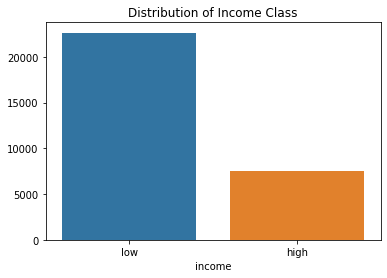

In [1544]:
sns.countplot(x='income',data=Census);
plt.title("Distribution of Income Class");
plt.ylabel('')

## Continuous Variables

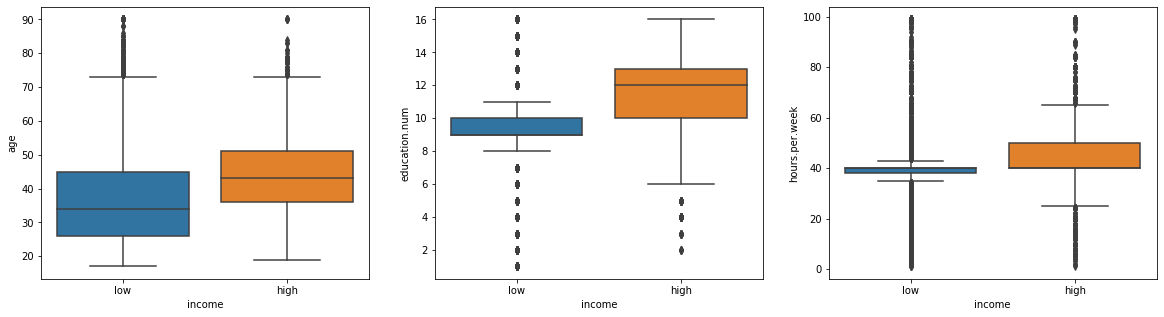

In [1545]:
%matplotlib inline
fig,ax = plt.subplots(1,3,figsize=(20,5))
sns.boxplot(x='income', y= 'age',data=Census,ax=ax[0]);
sns.boxplot(x='income', y= 'education.num',data=Census,ax=ax[1]);
sns.boxplot(x='income', y= 'hours.per.week',data=Census,ax=ax[2]);

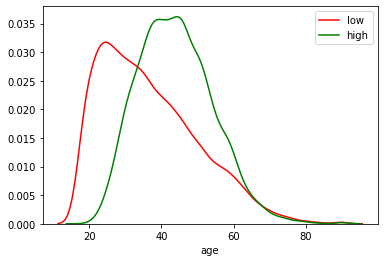

In [1546]:
sns.distplot(Census.loc[Census['income']=='low', 'age'],label='low',color='red',hist=False);
sns.distplot(Census.loc[Census['income']=='high', 'age'],label='high',color = 'green',hist=False);
plt.show()

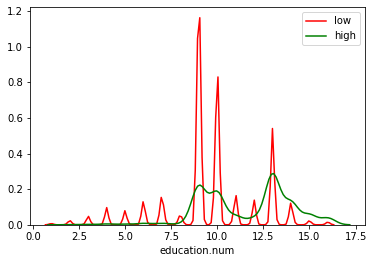

In [1547]:
sns.distplot(Census.loc[Census['income']=='low', 'education.num'],label='low',color = 'red',hist=False);
sns.distplot(Census.loc[Census['income']=='high', 'education.num'],label='high',color = 'green',hist=False);
plt.show()

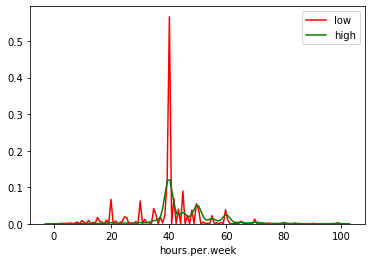

In [1548]:
sns.distplot(Census.loc[Census['income']=='low', 'hours.per.week'],label='low',color = 'red',hist=False);
sns.distplot(Census.loc[Census['income']=='high', 'hours.per.week'],label='high',color = 'green',hist=False);
plt.show()

We can see from the below contingency table education and education.num are correlated. We can drop education column for further analysis

In [1549]:
cont_table = pd.crosstab(Census["education"],Census["education.num"], margins = False)
cont_table

education.num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,820,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1048,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,377,0,0,0,0,0,0,0,0
1st-4th,0,149,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,287,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,556,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,455,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1008,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,1307,0,0,0,0,0


In [1372]:
Census= Census.drop(columns=['education'])
Census_test= Census_test.drop(columns=['education'])

## ChiSquare Test

In [1373]:
class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)
        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)

In [1374]:
cT = ChiSquare(Census)
testColumns = ['workclass','marital.status','occupation','race','sex']
for var in testColumns:
    cT.TestIndependence(colX=var,colY="income" )

workclass is IMPORTANT for Prediction
marital.status is IMPORTANT for Prediction
occupation is IMPORTANT for Prediction
race is IMPORTANT for Prediction
sex is IMPORTANT for Prediction


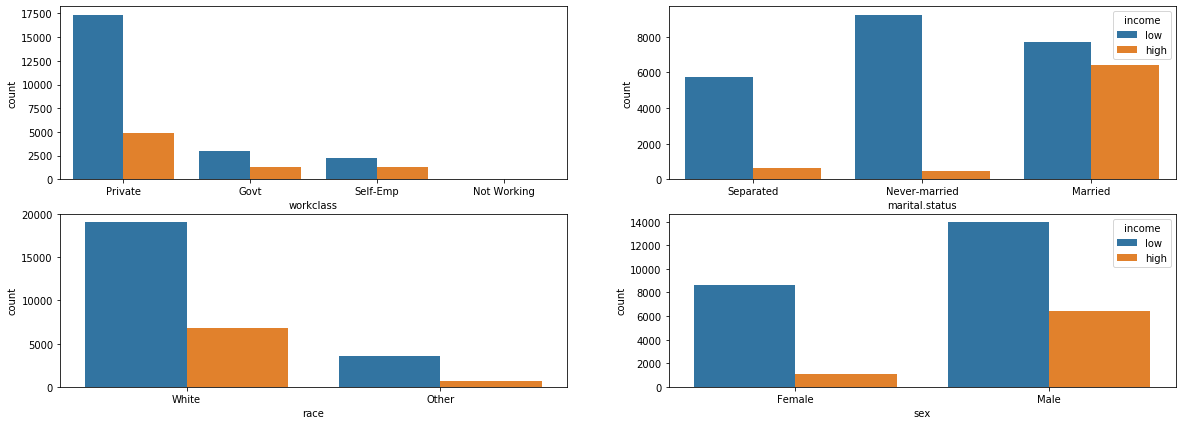

In [1375]:
%matplotlib inline
fig,ax = plt.subplots(2,2,figsize=(20,7))
sns.countplot(Census['workclass'],hue=Census['income'],ax=ax[0,0]);
ax[0,0].get_legend().set_visible(False)
plt.ylabel(' ')
sns.countplot(Census['marital.status'],hue= Census['income'], ax=ax[0,1]);
sns.countplot(Census['race'],hue= Census['income'],ax = ax[1,0]);
ax[1,0].get_legend().set_visible(False)
sns.countplot(Census['sex'],hue= Census['income'],ax = ax[1,1]);

In [1559]:
Census.groupby(['occupation','income']).agg({'race':'count'})

race
occupation      income      
Adm-clerical    high     498
                low     3221
Craft-repair    high     908
                low     3117
Exec-managerial high    1937
                low     2054
Other           high    1383
                low     9403
Prof-specialty  high    1810
                low     2224
Sales           high     970
                low     2614

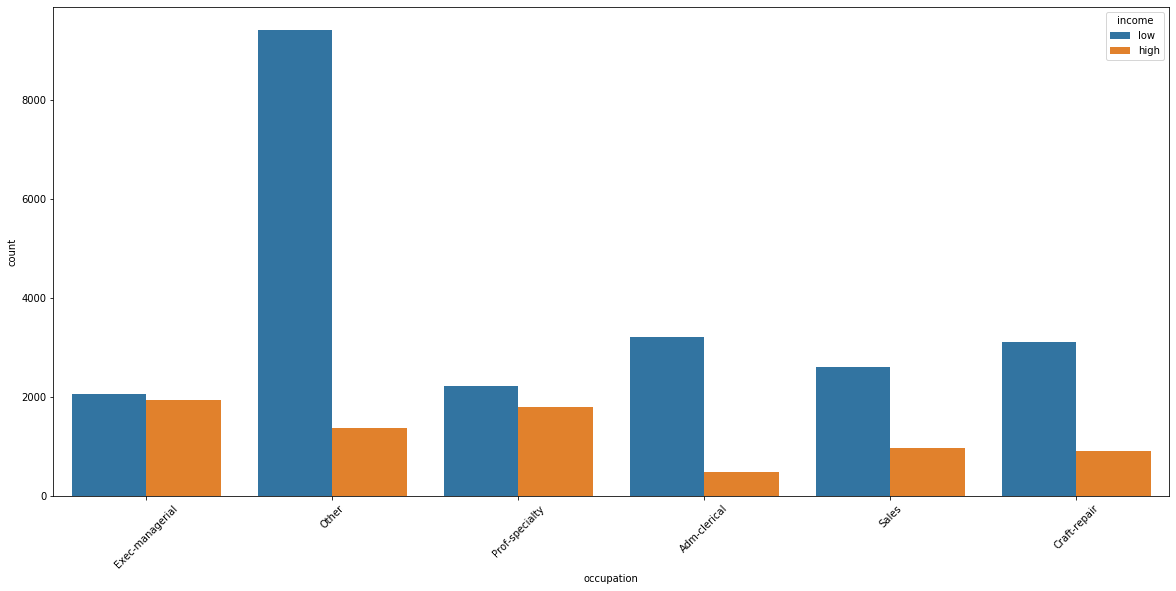

In [1376]:
fig,ax = plt.subplots(1,1,figsize=(20,9))
chart = sns.countplot(Census['occupation'],hue=Census['income']);
ax.set_xticklabels(chart.get_xticklabels(),rotation=45);

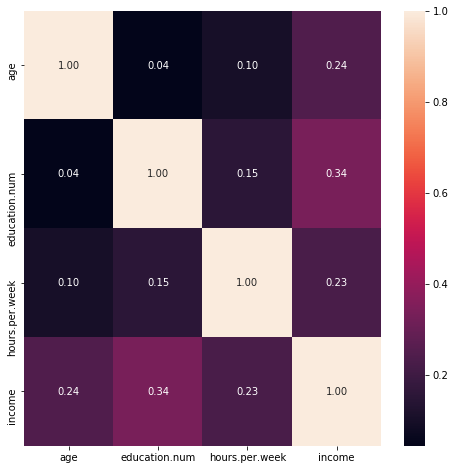

<Figure size 432x288 with 0 Axes>

In [1509]:
plt.figure(figsize=(8,8))
sns.heatmap(Census.corr(),annot=True,fmt='.2f')
plt.show()

# Feature Selection

## Using AIC

The following output is generated when stepwise AIC function in R is used. The following variables are important when AIC criteria is considered
- Marital Status
- Education.Num
- Income Overall
- Occupation
- Hours.per.week
- age
- sex
- native.country
- workclass
- race

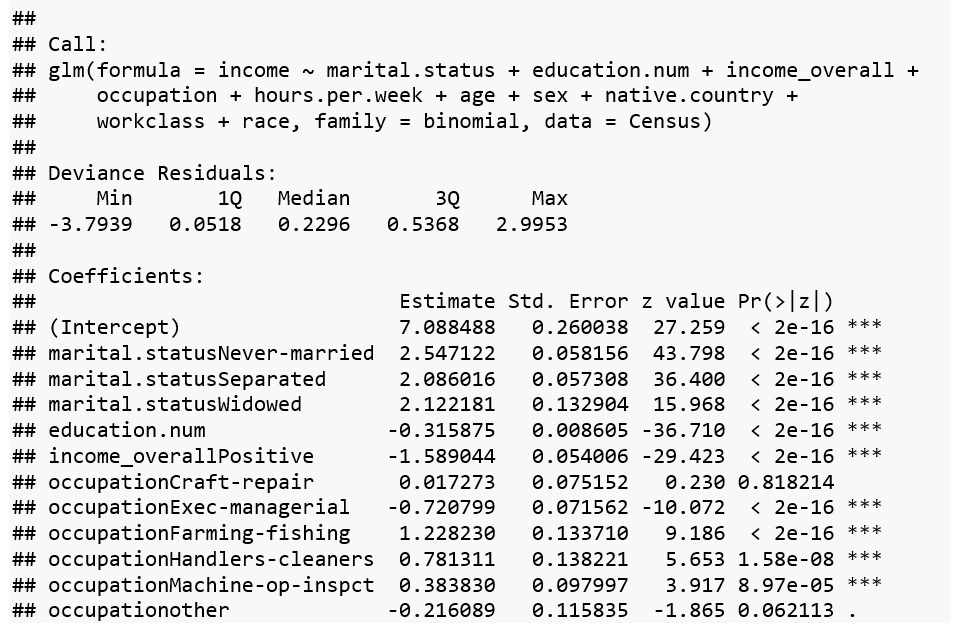

In [1378]:
Image("C:/Personal/UC BANA Flex 5/Capstone/AIC_Results_1.png")

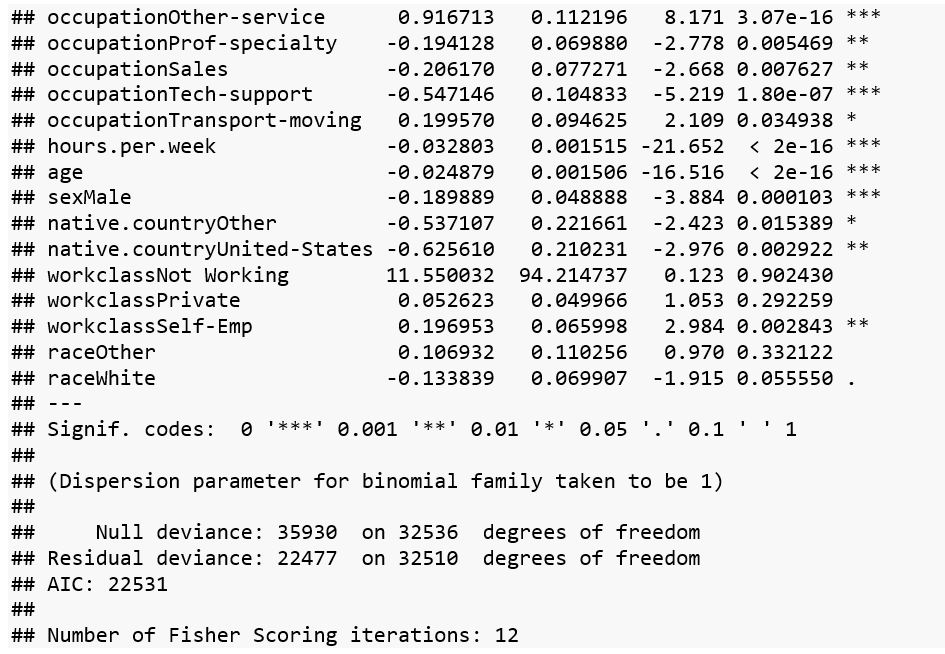

In [1379]:
Image("C:/Personal/UC BANA Flex 5/Capstone/AIC_Results_2.png")

## Using BIC

The following output is generated when stepwise BIC function in R is used. The following variables are important when BIC criteria is considered
- Marital Status
- Education.Num
- Income Overall
- Occupation
- Hours.per.week
- age
- sex

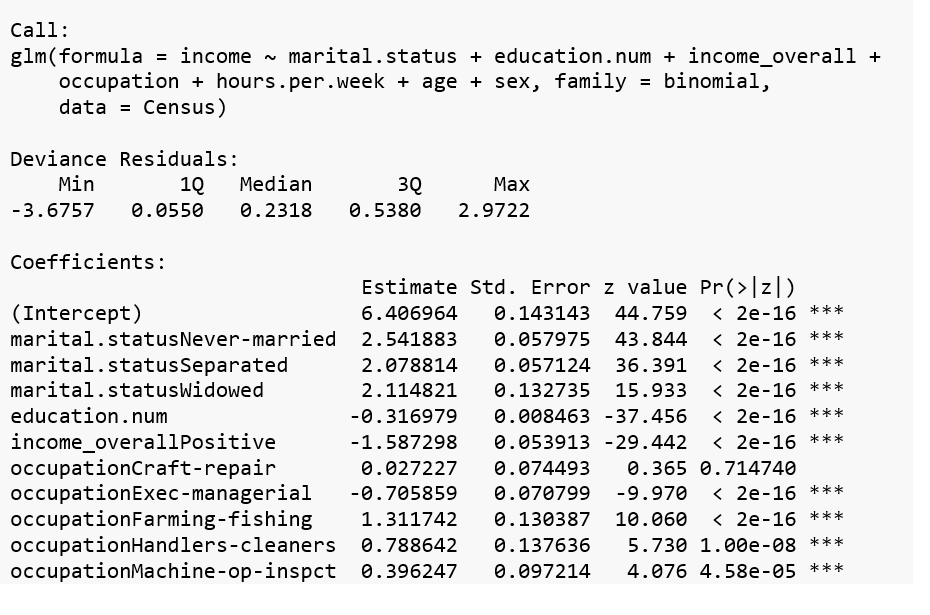

In [1380]:
Image("C:/Personal/UC BANA Flex 5/Capstone/BIC_results_1.png")

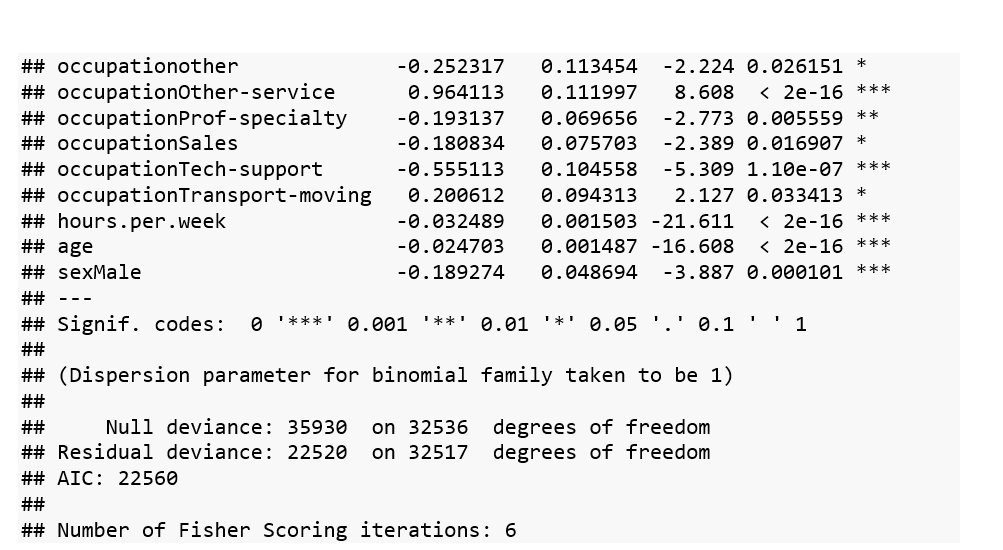

In [1381]:
Image("C:/Personal/UC BANA Flex 5/Capstone/BIC_results_2.png")

## Using Lasso

In [1382]:
X_lasso = Census.copy()
X_lasso = X_lasso.drop(columns='income')
Y_lasso = Census['income']
X_lasso_encoded = pd.get_dummies(columns=['workclass','marital.status','occupation','race','sex','income_overall'],data=
                                X_lasso,drop_first=True)
Lr = LogisticRegression(fit_intercept=True,penalty='l1',solver='liblinear')
Lr.fit(X_lasso_encoded,Y_lasso)
Results = pd.DataFrame({'columns':X_lasso_encoded.columns,'coeff':Lr.coef_.flatten()})

In [1383]:
Results.sort_values(by='coeff')

,columns,coeff
15,income_overall_Positive,-1.580865
9,occupation_Exec-managerial,-0.771880
11,occupation_Prof-specialty,-0.434100
1,education.num,-0.306858
12,occupation_Sales,-0.245364
14,sex_Male,-0.235973
13,race_White,-0.171827
2,hours.per.week,-0.029026
0,age,-0.027053
8,occupation_Craft-repair,0.033808


In [1384]:
Census_decoded =  pd.get_dummies(columns=['workclass','marital.status','occupation','race','sex','income_overall'],data=Census)

In [1385]:
RF = RandomForestClassifier()
X_RF = Census_decoded.loc[ :, Census_decoded.columns != "income"]
RF.fit(X_RF, Census_decoded["income"]);

In [1386]:
Feature_Importances = pd.DataFrame({'features':X_RF.columns,'Coeff':RF.feature_importances_})

In [1387]:
Feature_Importances = Feature_Importances.sort_values(by='Coeff',ascending=False).reset_index(drop=True)

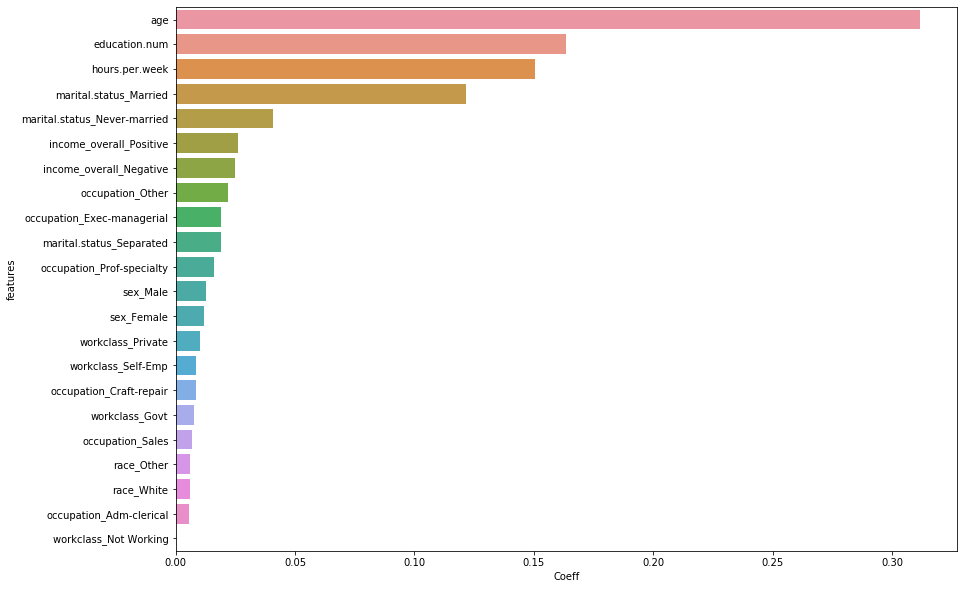

In [1388]:
plt.figure(figsize=(14,10))
sns.barplot(x='Coeff',y='features',data = Feature_Importances);

In [1389]:
Feature_Importances.loc[Feature_Importances['Coeff']<0.01,:]

,features,Coeff
14,workclass_Self-Emp,0.008704
15,occupation_Craft-repair,0.008499
16,workclass_Govt,0.007757
17,occupation_Sales,0.006977
18,race_Other,0.006200
19,race_White,0.006156
20,occupation_Adm-clerical,0.005702
21,workclass_Not Working,0.000118


In [1390]:
Census['income'] = [1 if x=='high' else 0 for x in Census['income']]


In [1391]:
Census_test['income'] = [1 if x=='high' else 0 for x in Census_test['income']]

In [1392]:
Summary = pd.DataFrame(columns=['model','train-test','accuracy','AUC','precision','recall','f1'])

# Train Test Split

In [1393]:
X = Census.loc[:,Census.columns !='income']
y = Census['income']

In [1394]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3,random_state=13261058)

# Encoding categorical variables

In [1395]:
X_train_encoded = pd.get_dummies(columns= ['workclass','marital.status','occupation','race','sex','income_overall'],data=X_train )
X_val_encoded = pd.get_dummies(columns= ['workclass','marital.status','occupation','race','sex','income_overall'],data=X_val )

Dropping few variables to avoid multicolinearity 

In [1396]:
X_train_encoded = X_train_encoded.drop(columns = ['workclass_Self-Emp','marital.status_Separated','occupation_Adm-clerical','race_Other','sex_Female','income_overall_Negative'])
X_val_encoded = X_val_encoded.drop(columns = ['workclass_Self-Emp','marital.status_Separated','occupation_Adm-clerical','race_Other','sex_Female','income_overall_Negative'])

# Modeling

## Logistic Regression - All Variables

In [1397]:
LR = LogisticRegression()
LR.fit(X_train_encoded,y_train)

C:\Users\mukka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [1398]:
LR_precision = precision_score(y_train,LR.predict(X_train_encoded))
LR_recall = recall_score(y_train,LR.predict(X_train_encoded))
LR_accuracy = accuracy_score(y_train,LR.predict(X_train_encoded))
LR_f1 = f1_score(y_train,LR.predict(X_train_encoded))
LR_AUC = roc_auc_score(y_train,LR.predict_proba(X_train_encoded)[:,-1])

In [1399]:
Summary = Summary.append({"model":"Logistic Regression- All variables", 'train-test' : 'train','accuracy':LR_accuracy,'AUC':LR_AUC,'precision':LR_precision,'recall':LR_recall,'f1':LR_f1}, ignore_index=  True)

### validation Data

In [1400]:
LR_precision_val = precision_score(y_val,LR.predict(X_val_encoded))
LR_recall_val = recall_score(y_val,LR.predict(X_val_encoded))
LR_accuracy_val = accuracy_score(y_val,LR.predict(X_val_encoded))
LR_f1_val = f1_score(y_val,LR.predict(X_val_encoded))
LR_AUC_val = roc_auc_score(y_val,LR.predict_proba(X_val_encoded)[:,-1])

In [1401]:
Summary = Summary.append({"model":"Logistic Regression- All variables", 'train-test' : 'val','accuracy':LR_accuracy_val,'AUC':LR_AUC_val,'precision':LR_precision_val,'recall':LR_recall_val,'f1':LR_f1_val}, ignore_index=  True)

# Logistic Regression - BIC Variables

In [1402]:
X_filtered_train = X_train_encoded.drop(columns=['race_White'])
X_filtered_val = X_val_encoded.drop(columns=['race_White'])

In [1403]:
LR = LogisticRegression()
LR.fit(X_filtered_train,y_train)

C:\Users\mukka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [1404]:
LR_precision_subset = precision_score(y_train,LR.predict(X_filtered_train))
LR_recall_subset = recall_score(y_train,LR.predict(X_filtered_train))
LR_accuracy_subset = accuracy_score(y_train,LR.predict(X_filtered_train))
LR_f1_subset = f1_score(y_train,LR.predict(X_filtered_train))
LR_AUC_subset = roc_auc_score(y_train,LR.predict_proba(X_filtered_train)[:,-1])

In [1405]:
Summary = Summary.append({"model":"Logistic Regression- BIC Variables", 'train-test' : 'train','accuracy':LR_accuracy_subset,'AUC':LR_AUC_subset,'precision':LR_precision_subset,'recall':LR_recall_subset,'f1':LR_f1_subset}, ignore_index=  True)

### Validation Data

In [1406]:
LR_precision_subset_val = precision_score(y_val,LR.predict(X_filtered_val))
LR_recall_subset_val = recall_score(y_val,LR.predict(X_filtered_val))
LR_accuracy_subset_val = accuracy_score(y_val,LR.predict(X_filtered_val))
LR_f1_subset_val = f1_score(y_val,LR.predict(X_filtered_val))
LR_AUC_subset_val = roc_auc_score(y_val,LR.predict_proba(X_filtered_val)[:,-1])

In [1407]:
Summary = Summary.append({"model":"Logistic Regression- BIC Variables", 'train-test' : 'val','accuracy':LR_accuracy_subset_val,'AUC':LR_AUC_subset_val,'precision':LR_precision_subset_val,'recall':LR_recall_subset_val,'f1':LR_f1_subset_val}, ignore_index=  True)

# Decision Tree

In [1408]:
DT = DecisionTreeClassifier(max_depth=10,random_state=13261058)
DT.fit(X_train_encoded,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=13261058, splitter='best')

In [1409]:
DT_precision = precision_score(y_train,DT.predict(X_train_encoded))
DT_recall = recall_score(y_train,DT.predict(X_train_encoded))
DT_accuracy = accuracy_score(y_train,DT.predict(X_train_encoded))
DT_f1 = f1_score(y_train,DT.predict(X_train_encoded))
DT_AUC = roc_auc_score(y_train,DT.predict_proba(X_train_encoded)[:,-1])

In [1410]:
Summary = Summary.append({"model":"Decision Tree", 'train-test' : 'train','accuracy':DT_accuracy,'AUC':DT_AUC,'precision':DT_precision,'recall':DT_recall,'f1':DT_f1}, ignore_index=  True)

### validation Data

In [1411]:
DT_precision_val = precision_score(y_val,DT.predict(X_val_encoded))
DT_recall_val = recall_score(y_val,DT.predict(X_val_encoded))
DT_accuracy_val = accuracy_score(y_val,DT.predict(X_val_encoded))
DT_f1_val = f1_score(y_val,DT.predict(X_val_encoded))
DT_AUC_val = roc_auc_score(y_val,DT.predict_proba(X_val_encoded)[:,-1])

In [1412]:
Summary = Summary.append({"model":"Decision Tree", 'train-test' : 'val','accuracy':DT_accuracy_val,'AUC':DT_AUC_val,'precision':DT_precision_val,'recall':DT_recall_val,'f1':DT_f1_val}, ignore_index=  True)

# Ada Boost

In [1413]:
ada = AdaBoostClassifier(n_estimators= 50,learning_rate = 0.1, random_state = 24)

In [1414]:
ada.fit(X_train_encoded,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=50, random_state=24)

In [1415]:
Ada_precision = precision_score(y_train,ada.predict(X_train_encoded))
Ada_recall = recall_score(y_train,ada.predict(X_train_encoded))
Ada_accuracy = accuracy_score(y_train,ada.predict(X_train_encoded))
Ada_f1 = f1_score(y_train,ada.predict(X_train_encoded))
Ada_AUC = roc_auc_score(y_train,ada.predict_proba(X_train_encoded)[:,-1])

In [1416]:
Summary = Summary.append({"model":"Ada Boosting", 'train-test' : 'train','accuracy':Ada_accuracy,'AUC':Ada_AUC,'precision':Ada_precision,'recall':Ada_recall,'f1':Ada_f1}, ignore_index=  True)

## Validation Data

In [1417]:
Ada_precision_val = precision_score(y_val,ada.predict(X_val_encoded))
Ada_recall_val = recall_score(y_val,ada.predict(X_val_encoded))
Ada_accuracy_val = accuracy_score(y_val,ada.predict(X_val_encoded))
Ada_f1_val = f1_score(y_val,ada.predict(X_val_encoded))
Ada_AUC_val = roc_auc_score(y_val,ada.predict_proba(X_val_encoded)[:,-1])

In [1418]:
Summary = Summary.append({"model":"Ada Boosting", 'train-test' : 'val','accuracy':Ada_accuracy_val,'AUC':Ada_AUC_val,'precision':Ada_precision_val,'recall':Ada_recall_val,'f1':Ada_f1_val}, ignore_index=  True)

# Random Forest

In [1419]:
RF = RandomForestClassifier(n_estimators = 100, max_depth = 10)
RF.fit(X_train_encoded,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1420]:
RF_precision = precision_score(y_train,RF.predict(X_train_encoded))
RF_recall = recall_score(y_train,RF.predict(X_train_encoded))
RF_accuracy = accuracy_score(y_train,RF.predict(X_train_encoded))
RF_f1 = f1_score(y_train,RF.predict(X_train_encoded))
RF_AUC = roc_auc_score(y_train,RF.predict_proba(X_train_encoded)[:,-1])

In [1421]:
Summary = Summary.append({"model":"Random Forest", 'train-test' : 'train','accuracy':RF_accuracy,'AUC':RF_AUC,'precision':RF_precision,'recall':RF_recall,'f1':RF_f1}, ignore_index=  True)

### Validation Data

In [1422]:
RF_precision_val = precision_score(y_val,RF.predict(X_val_encoded))
RF_recall_val = recall_score(y_val,RF.predict(X_val_encoded))
RF_accuracy_val = accuracy_score(y_val,RF.predict(X_val_encoded))
RF_f1_val = f1_score(y_val,RF.predict(X_val_encoded))
RF_AUC_val = roc_auc_score(y_val,RF.predict_proba(X_val_encoded)[:,-1])

In [1423]:
Summary = Summary.append({"model":"Random Forest", 'train-test' : 'val','accuracy':RF_accuracy_val,'AUC':RF_AUC_val,'precision':RF_precision_val,'recall':RF_recall_val,'f1':RF_f1_val}, ignore_index=  True)

# XGBOOST

In [1424]:
xgb = XGBClassifier(max_depth = 5, learning_rate=0.1)
xgb.fit(X_train_encoded,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [1425]:
XGB_precision = precision_score(y_train,xgb.predict(X_train_encoded))
XGB_recall = recall_score(y_train,xgb.predict(X_train_encoded))
XGB_accuracy = accuracy_score(y_train,xgb.predict(X_train_encoded))
XGB_f1 = f1_score(y_train,xgb.predict(X_train_encoded))
XGB_AUC = roc_auc_score(y_train,xgb.predict_proba(X_train_encoded)[:,-1])

In [1426]:
Summary = Summary.append({"model":"XGBoost", 'train-test' : 'train','accuracy':XGB_accuracy,'AUC':XGB_AUC,'precision':XGB_precision,'recall':XGB_recall,'f1':XGB_f1}, ignore_index=  True)

## Validation Data

In [1427]:
XGB_precision_val = precision_score(y_val,xgb.predict(X_val_encoded))
XGB_recall_val = recall_score(y_val,xgb.predict(X_val_encoded))
XGB_accuracy_val = accuracy_score(y_val,xgb.predict(X_val_encoded))
XGB_f1_val = f1_score(y_val,xgb.predict(X_val_encoded))
XGB_AUC_val = roc_auc_score(y_val,xgb.predict_proba(X_val_encoded)[:,-1])

In [1428]:
Summary = Summary.append({"model":"XGBoost", 'train-test' : 'val','accuracy':XGB_accuracy_val,'AUC':XGB_AUC_val,'precision':XGB_precision_val,'recall':XGB_recall_val,'f1':XGB_f1_val}, ignore_index=  True)

# SVM

In [1429]:
svm = SVC(kernel = "rbf", C = 1, gamma = "auto")

In [1430]:
svm.fit(X_train_encoded,y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1431]:
svm_precision = precision_score(y_train,svm.predict(X_train_encoded))
svm_recall = recall_score(y_train,svm.predict(X_train_encoded))
svm_accuracy = accuracy_score(y_train,svm.predict(X_train_encoded))
svm_f1 = f1_score(y_train,svm.predict(X_train_encoded))
#svm_AUC = roc_auc_score(y_train,svm.predict_proba(X_train_encoded)[:,-1])

In [1432]:
Summary = Summary.append({"model":"SVM", 'train-test' : 'train','accuracy':svm_accuracy,'AUC': 0 ,'precision':svm_precision,'recall':svm_recall,'f1':svm_f1}, ignore_index=  True)

## Validation Data

In [1433]:
svm_precision_val = precision_score(y_val,svm.predict(X_val_encoded))
svm_recall_val = recall_score(y_val,svm.predict(X_val_encoded))
svm_accuracy_val = accuracy_score(y_val,svm.predict(X_val_encoded))
svm_f1_val = f1_score(y_val,svm.predict(X_val_encoded))
#svm_AUC = roc_auc_score(y_train,svm.predict_proba(X_train_encoded)[

In [1434]:
Summary = Summary.append({"model":"SVM", 'train-test' : 'val','accuracy':svm_accuracy_val,'AUC': 0 ,'precision':svm_precision_val,'recall':svm_recall_val,'f1':svm_f1_val}, ignore_index=  True)

# PCA

## Standardizing the data

In [1458]:
std_scale = StandardScaler().fit(X_train_encoded)
X_scaled = std_scale.transform(X_train_encoded)
y = y_train

In [1461]:
pca = PCA(n_components=2)
PrincipalComponents = pca.fit_transform(X_scaled)

In [1464]:
PC_DF = pd.DataFrame(data = PrincipalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [1490]:
index = []
Variance_explained = []
for i in range(14):
    pca = PCA(n_components=i)
    PrincipalComponents = pca.fit_transform(X_scaled)
    index.append(i)
    Variance_explained.append(np.sum(pca.explained_variance_ratio_))

In [1491]:
variance_df = pd.DataFrame({'components':index,'Variance':Variance_explained})

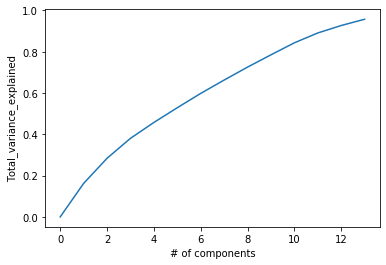

In [1496]:
sns.lineplot(x='components',y = 'Variance',data=variance_df);
plt.xlabel('# of components');
plt.ylabel('Total_variance_explained');

In [1499]:
pca = PCA(n_components=10)
PrincipalComponents = pca.fit_transform(X_scaled)
PC_DF = pd.DataFrame(data=PrincipalComponents,columns=['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8',
                                                      'pc9','pc10'])

In [1500]:
LR.fit(PC_DF,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [1501]:
std_scale_val = StandardScaler().fit(X_val_encoded)
X_scaled_val = std_scale_val.transform(X_val_encoded)
PrincipalComponents_val = pca.fit_transform(X_scaled_val)

In [1502]:
PC_DF_val = pd.DataFrame(data=PrincipalComponents_val,columns=['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8',
                                                      'pc9','pc10'])

In [1613]:
LR.fit(PC_DF,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [1617]:
pd.DataFrame({'components':PC_DF.columns, 'coeff' :LR.coef_[0],'odds_ratio':np.exp(LR.coef_[0])}).to_csv("C:/Personal/UC BANA Flex 5/Capstone/Report/PC_LR.csv")

Since XGBoost performance is better compared to all other models. We can fit XGBoost to the principal components and see if it improves the performance.

In [1604]:
xgb.fit(PC_DF,y_train)
XGB_precision_prin = precision_score(y_train,xgb.predict(PC_DF))
XGB_recall_prin = recall_score(y_train,xgb.predict(PC_DF))
XGB_accuracy_prin = accuracy_score(y_train,xgb.predict(PC_DF))
XGB_f1_prin = f1_score(y_train,xgb.predict(PC_DF))
XGB_AUC_prin = roc_auc_score(y_train,xgb.predict_proba(PC_DF)[:,-1])

In [1605]:
Summary = Summary.append({"model":"XGBoost and PCA", 'train-test' : 'train','accuracy':XGB_accuracy_prin,'AUC': XGB_AUC_prin ,'precision':XGB_precision_prin,'recall':XGB_recall_prin,'f1':XGB_f1_prin}, ignore_index=  True)

In [1607]:
xgb.fit(PC_DF,y_train)
XGB_precision_prin_val = precision_score(y_val,xgb.predict(PC_DF_val))
XGB_recall_prin_val = recall_score(y_val,xgb.predict(PC_DF_val))
XGB_accuracy_prin_val = accuracy_score(y_val,xgb.predict(PC_DF_val))
XGB_f1_prin_val = f1_score(y_val,xgb.predict(PC_DF_val))
XGB_AUC_prin_val = roc_auc_score(y_val,xgb.predict_proba(PC_DF_val)[:,-1])

In [1609]:
Summary = Summary.append({"model":"XGBoost and PCA", 'train-test' : 'val','accuracy':XGB_accuracy_prin_val,'AUC': XGB_AUC_prin_val ,'precision':XGB_precision_prin_val,'recall':XGB_recall_prin_val,'f1':XGB_f1_prin_val}, ignore_index=  True)

In [1610]:
Summary

,model,train-test,accuracy,AUC,precision,recall,f1
0,Logistic Regression- All variables,train,0.831540,0.884941,0.703695,0.558454,0.622718
1,Logistic Regression- All variables,val,0.829131,0.888617,0.697054,0.556344,0.618801
2,Logistic Regression- BIC Variables,train,0.831587,0.884592,0.706741,0.552932,0.620447
3,Logistic Regression- BIC Variables,val,0.828688,0.887494,0.699717,0.547915,0.614581
4,Decision Tree,train,0.856994,0.922205,0.754730,0.630427,0.687001
5,Decision Tree,val,0.824818,0.862790,0.674661,0.574091,0.620326
6,Ada Boosting,train,0.827558,0.883336,0.753137,0.457159,0.568957
7,Ada Boosting,val,0.826587,0.882563,0.746055,0.461402,0.570175
8,Random Forest,train,0.858368,0.924921,0.782859,0.596535,0.677113
9,Random Forest,val,0.837204,0.895746,0.725751,0.557675,0.630707


In [1573]:
classifiers = [LR, 
               DT,
               ada,
               RF,
               xgb
               ]

In [1574]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

In [1586]:
result_table_train = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

In [1587]:
for cls in classifiers:
    model = cls.fit(X_train_encoded, y_train)
    yproba = model.predict_proba(X_train_encoded)[::,1]
    
    fpr, tpr, _ = roc_curve(y_train,  yproba)
    auc = roc_auc_score(y_train, yproba)
    
    result_table_train = result_table_train.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

C:\Users\mukka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [1589]:
result_table_train = result_table_train.set_index('classifiers')

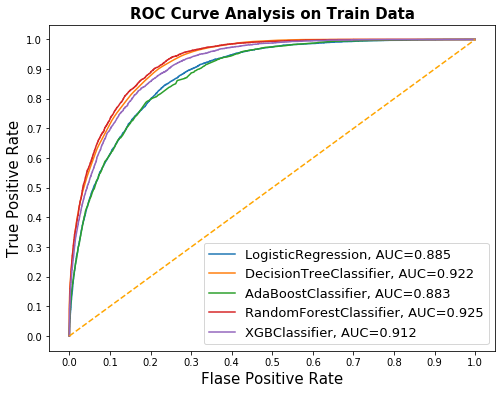

In [1590]:
fig = plt.figure(figsize=(8,6))

for i in result_table_train.index:
    plt.plot(result_table_train.loc[i]['fpr'], 
             result_table_train.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table_train.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis on Train Data', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [1575]:
for cls in classifiers:
    model = cls.fit(X_train_encoded, y_train)
    yproba = model.predict_proba(X_val_encoded)[::,1]
    
    fpr, tpr, _ = roc_curve(y_val,  yproba)
    auc = roc_auc_score(y_val, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

C:\Users\mukka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [1583]:
result_table = result_table.set_index('classifiers')

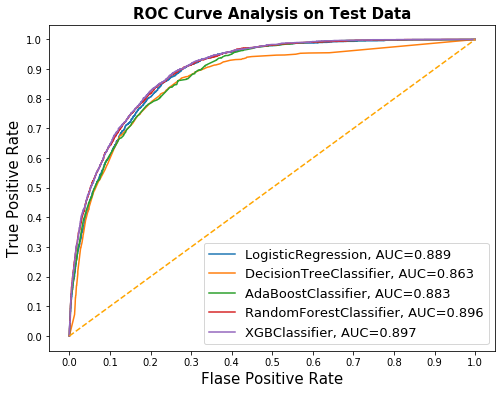

In [1585]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis on Test Data', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# Encoding Test Data

In [1435]:
X_test = Census_test.loc[:,Census.columns !='income']
y_test = Census_test['income']

In [1436]:
X_test_encoded = pd.get_dummies(columns= ['workclass','marital.status','occupation','race','sex','income_overall'],data=X_test )


Dropping variables to avoid multicollinearity

In [1437]:
X_test_encoded = X_test_encoded.drop(columns = ['workclass_Self-Emp','marital.status_Separated','occupation_Adm-clerical','race_Other','sex_Female','income_overall_Negative'])

# Validating Test Data

## Logistic Regression- All Variables

In [1438]:
LR.fit(X_train_encoded,y_train)
LR_precision_test = precision_score(y_test,LR.predict(X_test_encoded))
LR_recall_test = recall_score(y_test,LR.predict(X_test_encoded))
LR_accuracy_test = accuracy_score(y_test,LR.predict(X_test_encoded))
LR_f1_test = f1_score(y_test,LR.predict(X_test_encoded))
LR_AUC_test = roc_auc_score(y_test,LR.predict_proba(X_test_encoded)[:,-1])

C:\Users\mukka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [1439]:
Summary = Summary.append({"model":"Logistic Regression- All variables", 'train-test' : 'test','accuracy':LR_accuracy_test,'AUC':LR_AUC_test,'precision':LR_precision_test,'recall':LR_recall_test,'f1':LR_f1_test}, ignore_index=  True)

In [1593]:
LR.coef_

array([[ 0.02524382,  0.31542307,  0.03030483,  0.02601124, -0.11282808,
         0.02392864,  2.00392023, -0.59123303, -0.55933841,  0.2806868 ,
        -0.84294696, -0.07404807, -0.33418717,  0.19144015,  0.34149019,
         1.61577661]])

In [1598]:
Impact_variables = pd.DataFrame({'feature':X_test_encoded.columns,'coeff':LR.coef_[0]})

In [1600]:
Impact_variables['odds_ratio'] = np.exp(Impact_variables['coeff'])

In [1602]:
Impact_variables.to_csv("C:/Personal/UC BANA Flex 5/Capstone/Report/Impact_variables.csv")

## Logistic Regression - BIC Variables

In [1440]:
X_filtered_test = X_test_encoded.drop(columns=['race_White'])

In [1441]:
LR.fit(X_filtered_train,y_train)
LR_precision_subset_test = precision_score(y_test,LR.predict(X_filtered_test))
LR_recall_subset_test = recall_score(y_test,LR.predict(X_filtered_test))
LR_accuracy_subset_test = accuracy_score(y_test,LR.predict(X_filtered_test))
LR_f1_subset_test = f1_score(y_test,LR.predict(X_filtered_test))
LR_AUC_subset_test = roc_auc_score(y_test,LR.predict_proba(X_filtered_test)[:,-1])

C:\Users\mukka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [1442]:
Summary = Summary.append({"model":"Logistic Regression- BIC Variables", 'train-test' : 'test','accuracy':LR_accuracy_subset_test,'AUC':LR_AUC_subset_test,'precision':LR_precision_subset_test,'recall':LR_recall_subset_test,'f1':LR_f1_subset_test}, ignore_index=  True)

## Ada Boost

In [1443]:
Ada_precision_test = precision_score(y_test,ada.predict(X_test_encoded))
Ada_recall_test = recall_score(y_test,ada.predict(X_test_encoded))
Ada_accuracy_test = accuracy_score(y_test,ada.predict(X_test_encoded))
Ada_f1_test = f1_score(y_test,ada.predict(X_test_encoded))
Ada_AUC_test = roc_auc_score(y_test,ada.predict_proba(X_test_encoded)[:,-1])

In [1444]:
Summary = Summary.append({"model":"Ada Boosting", 'train-test' : 'test','accuracy':Ada_accuracy_test,'AUC':Ada_AUC_test,'precision':Ada_precision_test,'recall':Ada_recall_test,'f1':Ada_f1_test}, ignore_index=  True)

## Decision Tree

In [1445]:
DT_precision_test = precision_score(y_test,DT.predict(X_test_encoded))
DT_recall_test = recall_score(y_test,DT.predict(X_test_encoded))
DT_accuracy_test = accuracy_score(y_test,DT.predict(X_test_encoded))
DT_f1_test = f1_score(y_test,DT.predict(X_test_encoded))
DT_AUC_test = roc_auc_score(y_test,DT.predict_proba(X_test_encoded)[:,-1])

In [1446]:
Summary = Summary.append({"model":"Decision Tree", 'train-test' : 'test','accuracy':DT_accuracy_test,'AUC':DT_AUC_test,'precision':DT_precision_test,'recall':DT_recall_test,'f1':DT_f1_test}, ignore_index=  True)

## Random Forest

In [1447]:
RF_precision_test = precision_score(y_test,RF.predict(X_test_encoded))
RF_recall_test = recall_score(y_test,RF.predict(X_test_encoded))
RF_accuracy_test = accuracy_score(y_test,RF.predict(X_test_encoded))
RF_f1_test = f1_score(y_test,RF.predict(X_test_encoded))
RF_AUC_test = roc_auc_score(y_test,RF.predict_proba(X_test_encoded)[:,-1])

In [1448]:
Summary = Summary.append({"model":"Random Forest", 'train-test' : 'test','accuracy':RF_accuracy_test,'AUC':RF_AUC_test,'precision':RF_precision_test,'recall':RF_recall_test,'f1':RF_f1_test}, ignore_index=  True)

## XGBoost

In [1449]:
XGB_precision_test = precision_score(y_test,xgb.predict(X_test_encoded))
XGB_recall_test = recall_score(y_test,xgb.predict(X_test_encoded))
XGB_accuracy_test = accuracy_score(y_test,xgb.predict(X_test_encoded))
XGB_f1_test = f1_score(y_test,xgb.predict(X_test_encoded))
XGB_AUC_test = roc_auc_score(y_test,xgb.predict_proba(X_test_encoded)[:,-1])

In [1450]:
Summary = Summary.append({"model":"XGBoost", 'train-test' : 'test','accuracy':XGB_accuracy_test,'AUC':XGB_AUC_test,'precision':XGB_precision_test,'recall':XGB_recall_test,'f1':XGB_f1_test}, ignore_index=  True)

## SVM

In [1451]:
svm_precision_test = precision_score(y_test,svm.predict(X_test_encoded))
svm_recall_test = recall_score(y_test,svm.predict(X_test_encoded))
svm_accuracy_test = accuracy_score(y_test,svm.predict(X_test_encoded))
svm_f1_test = f1_score(y_test,svm.predict(X_test_encoded))
#svm_AUC = roc_auc_score(y_train,svm.predict_proba(X_train_encoded)[

In [1452]:
Summary = Summary.append({"model":"SVM", 'train-test' : 'test','accuracy':svm_accuracy_test,'AUC': 0 ,'precision':svm_precision_test,'recall':svm_recall_test,'f1':svm_f1_test}, ignore_index=  True)